# Preparação do Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
try:
    from google.colab import drive
    diretorio = 'drive/My Drive/tor/'
    drive.mount('/content/drive')
except:
    diretorio = ''

Mounted at /content/drive


In [3]:
from sklearn.utils import shuffle

df = pd.read_csv(diretorio + 'dataset.csv')
df.columns = [i.lower().strip().replace(' ', '_') for i in df.columns]
mantem = [
    'protocol', 'flow_duration',
    'fwd_iat_max', 'fwd_iat_min',
    'bwd_iat_max', 'bwd_iat_min', 'label'
]

## TCP = 6 -> 1 ; UDP = 17 -> 0
df['protocol'] = (df['protocol'] == 6).astype(int)

## TOR -> 1 ; nonTOR -> 0
df['label'] = (df['label'] == 'TOR').astype(int)

df = shuffle(df[mantem], random_state=21).reset_index(drop=True)

## Separar o dataset em 2 porções

In [4]:
int_80 = int(df.shape[0] * 0.8)

df_80 = df.loc[:int_80, :]
df_20 = df.loc[int_80:, :]

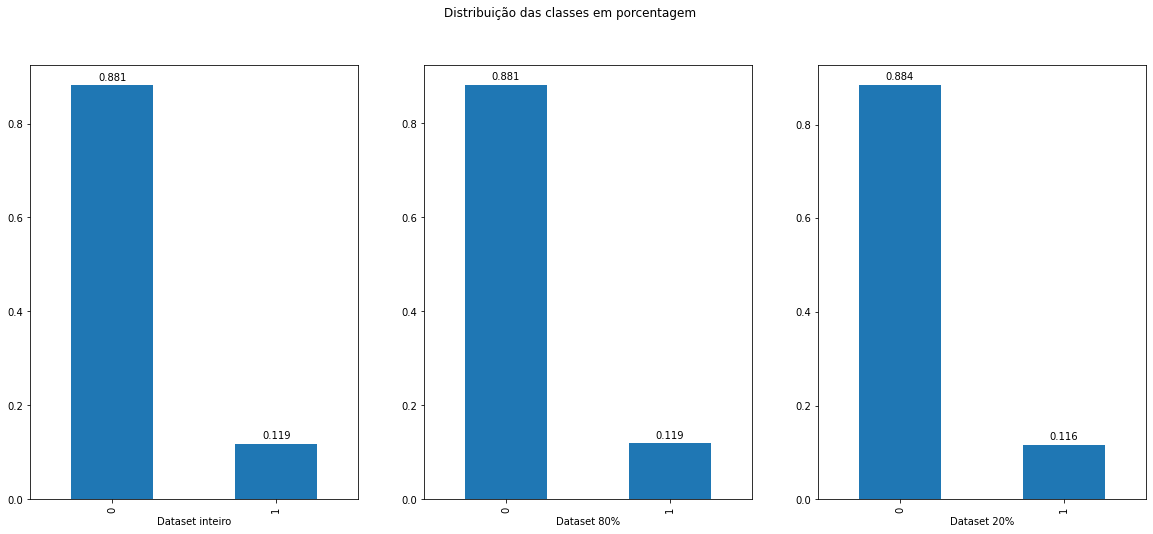

In [5]:
def adiciona_anotacao(axis):
    for rect in axis.patches:
        height = round(rect.get_height(), 3)
        axis.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
fig, axs = plt.subplots(1, 3, figsize=(20,8))
ax = df['label'].value_counts(normalize=True).plot.bar(ax=axs[0])
adiciona_anotacao(ax)
ax.set_xlabel('Dataset inteiro')

ax1 = df_80['label'].value_counts(normalize=True).plot.bar(ax=axs[1])
adiciona_anotacao(ax1)
ax1.set_xlabel('Dataset 80%')

ax2 =df_20['label'].value_counts(normalize=True).plot.bar(ax=axs[2])
adiciona_anotacao(ax2)
ax2.set_xlabel('Dataset 20%')

plt.suptitle('Distribuição das classes em porcentagem')
plt.show()

# Treinamento

In [6]:
X = df_80[mantem[:-1]]
y = df_80['label']

In [7]:
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split

from datetime import datetime

kf5 = KFold(n_splits=5)

In [8]:
def predict(clf, X_test, y_test):
    start_time = datetime.now()
    y_pred = clf.predict(X_test)
    predict_time = datetime.now() - start_time

    ## roc_curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    display_roc = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                          estimator_name='')
    
    ## confusion_matrix
    cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
    display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=['nonTOR', 'TOR'])
    tn, fp, fn, tp = cm.ravel()

    print('Tempo de predição:', predict_time)
    print()
    precisao = metrics.precision_score(y_test, y_pred)
    print('Precisão:', precisao)
    erro = (y_test != y_pred).sum() / len(y_test)
    print('Erro:', erro)
    
    fig, axs = plt.subplots(1, 2, figsize=(20,6))
    display_roc.plot(ax=axs[0])
    display_cm.plot(ax=axs[1], cmap=plt.cm.Purples)
    
    plt.show()

    return [precisao, erro, roc_auc, tn, tp]

In [9]:
def train_predict_percentage(ClassifierModel, **classifier_kwargs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=21)
    
    clf = make_pipeline(MinMaxScaler(feature_range=(0,1)),
                        ClassifierModel(**classifier_kwargs))

    start_time = datetime.now()
    clf.fit(X_train, y_train)
    train_time = datetime.now() - start_time
    
    print('Tempo de treino:', train_time)
    predict(clf, X_test, y_test)

    return clf

In [10]:
def train_predict_kfold(ClassifierModel, **classifier_kwargs):
    results = []
    for idx, (train_index, test_index) in enumerate(kf5.split(X)):
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = make_pipeline(MinMaxScaler(feature_range=(0,1)),
                            ClassifierModel(**classifier_kwargs))

        start_time = datetime.now()
        clf.fit(X_train, y_train)
        train_time = datetime.now() - start_time

        start_time = datetime.now()
        y_pred = clf.predict(X_test)
        predict_time = datetime.now() - start_time

        results.append((
            metrics.roc_auc_score(y_test, y_pred),
            idx,
            y_test,
            y_pred,
            train_time,
            predict_time,
        ))

    fig, axs = plt.subplots(1, 2, figsize=(20,6))

    ## roc_curve
    for _, idx, y_test, y_pred, _, _ in results:
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        display_roc = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                              estimator_name=f'Kfold {idx + 1}')
        display_roc.plot(ax=axs[0])
    
    _, idx, y_test, y_pred, train_t, predict_t = sorted(results,
                                                        reverse=True)[0]
    
    ## confusion_matrix
    cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
    display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=['nonTOR', 'TOR'])
    print('Melhor fold:', idx + 1)
    print('Tempo de treino:', train_t)
    print('Tempo de predição:', predict_t)
    print()
    print('Precisão:', metrics.precision_score(y_test, y_pred))
    print('Erro:', (y_test != y_pred).sum() / len(y_test))

    display_cm.plot(ax=axs[1], cmap=plt.cm.Purples)
    
    plt.show()

## KNN

Mudar os parâmetros de vizinhos e peso deu uma leve melhorada no modelo. Foi tentado outras alterações, mas não houve melhora no resultado.

|Parâmetro|Padrão|Valor Especificado|
|---|---|---|
|`n_neighbors`|5|4|
|`weights`|uniform|distance|

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
knn_params = { 'n_neighbors': 4, 'weights': 'distance' }

Tempo de treino: 0:00:01.207724
Tempo de predição: 0:00:00.274278

Precisão: 0.778988326848249
Erro: 0.049566979915238625


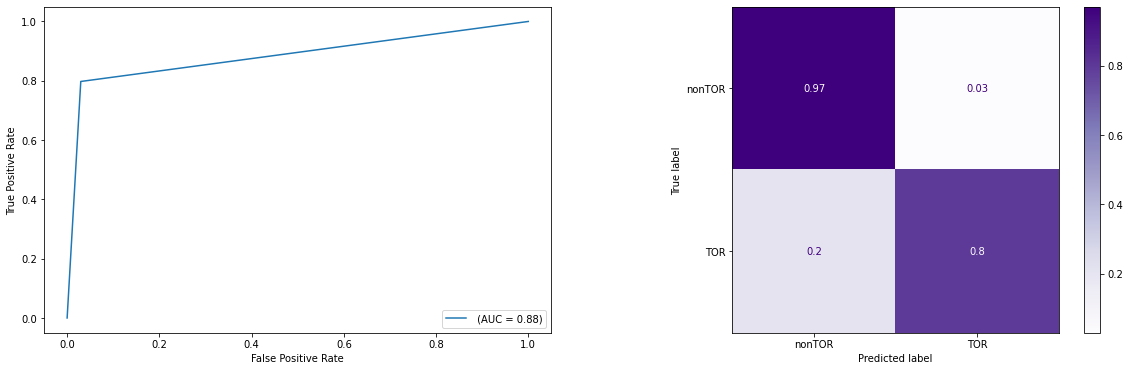

In [13]:
knn_0 = train_predict_percentage(KNeighborsClassifier, **knn_params)

Melhor fold: 3
Tempo de treino: 0:00:01.189804
Tempo de predição: 0:00:00.250755

Precisão: 0.7996857816182247
Erro: 0.04717154965911185


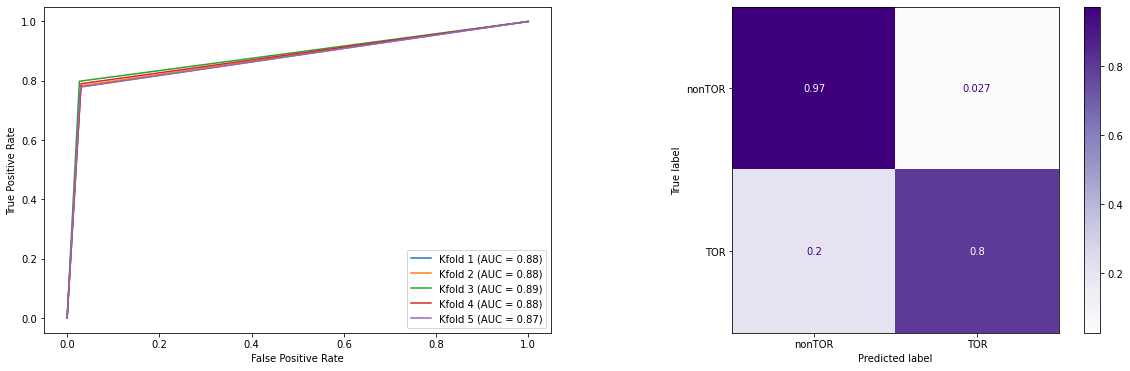

In [14]:
train_predict_kfold(KNeighborsClassifier, **knn_params)

## Random Forest

Nesse modelo eu só reduzi a quantidade de árvores na floresta e coloquei um número para deixar o randômico reproduzível.

|Parâmetro|Padrão|Valor Especificado|
|---|---|---|
|`n_estimators`|100|75|
|`random_state`|`None`|21|

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rf_params = { 'n_estimators': 75, 'random_state': 21 }

Tempo de treino: 0:00:02.885883
Tempo de predição: 0:00:00.094517

Precisão: 0.9021097046413502
Erro: 0.027823843744241756


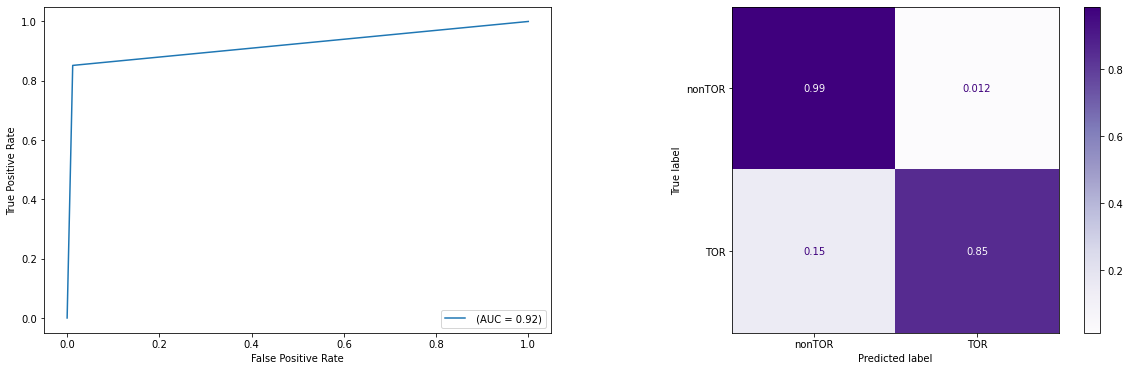

In [17]:
rf_0 = train_predict_percentage(RandomForestClassifier, **rf_params)

Melhor fold: 2
Tempo de treino: 0:00:02.819095
Tempo de predição: 0:00:00.088664

Precisão: 0.9115977291159773
Erro: 0.026810392482034272


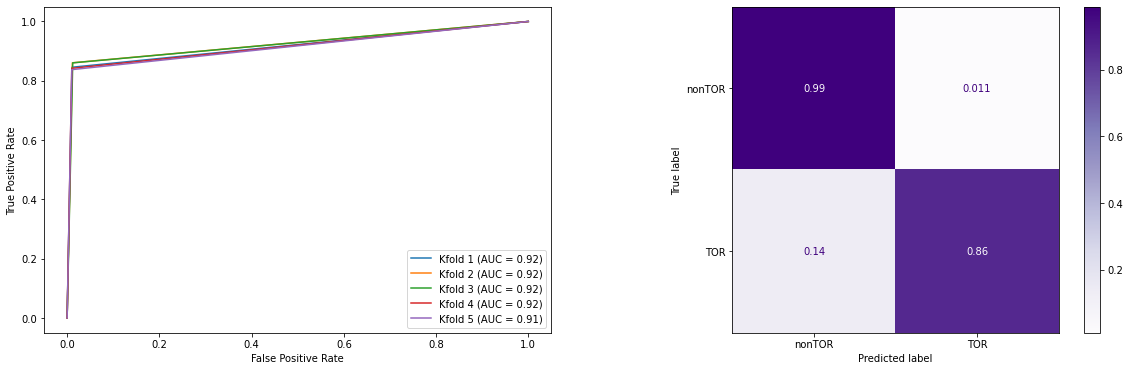

In [18]:
train_predict_kfold(RandomForestClassifier, **rf_params)

## Support Vector Machine

Devido a proporção de classes estar desbalanceada, foi preciso ajustar o class_weight.

|Parâmetro|Padrão|Valor Especificado|
|---|---|---|
|`class_weight`|`None`|balanced|
|`random_state`|`None`|21|
|`cache_size`|200|500|



In [19]:
from sklearn.svm import SVC

In [20]:
svm_params = {
    'class_weight': 'balanced', 'random_state': 21,
    'cache_size': 500
}

Tempo de treino: 0:00:30.522980
Tempo de predição: 0:00:02.845985

Precisão: 0.5174085500220361
Erro: 0.10834715312327253


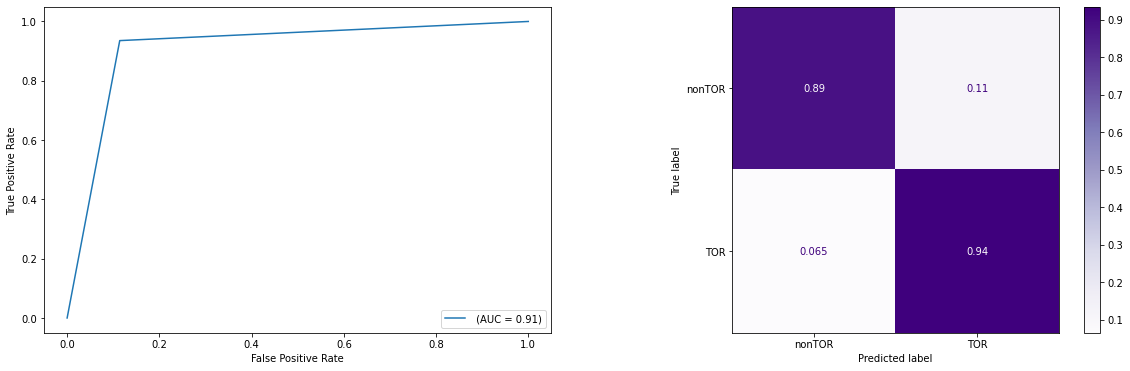

In [21]:
svm_0 = train_predict_percentage(SVC, **svm_params)

Melhor fold: 1
Tempo de treino: 0:00:30.220604
Tempo de predição: 0:00:02.852503

Precisão: 0.5488556338028169
Erro: 0.10189791781831582


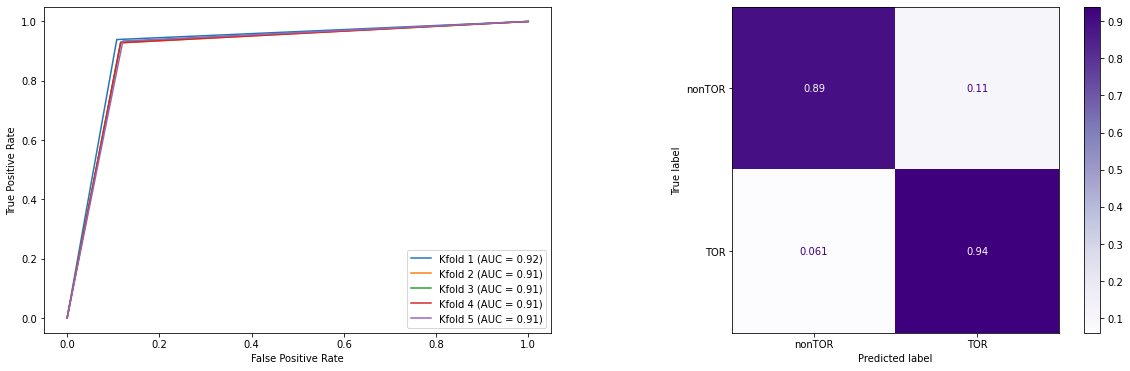

In [22]:
train_predict_kfold(SVC, **svm_params)

## Perceptron

Adicionar uma penalidade e aumentar um pouco o alpha deu uma simples melhora. A penalidade não pode ser `l1`, pois isso causa piora no desempenho.


|Parâmetro|Padrão|Valor Especificado|
|---|---|---|
|`penalty`|`None`|elasticnet|
|`alpha`|0.0001|0.0005|
|`random_state`|`None`|21|




In [23]:
from sklearn.linear_model import Perceptron

In [24]:
percep_params = { 'penalty': 'elasticnet', 'alpha': 0.0005, 'random_state': 21 }

Tempo de treino: 0:00:00.068559
Tempo de predição: 0:00:00.004434

Precisão: 0.5808988764044943
Erro: 0.08909157914133038


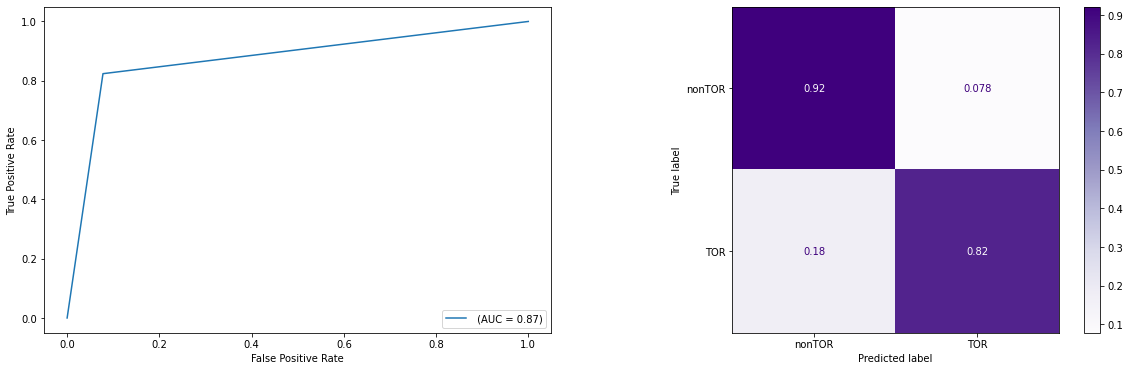

In [25]:
perceptron_0 = train_predict_percentage(Perceptron, **percep_params)

Melhor fold: 2
Tempo de treino: 0:00:00.083091
Tempo de predição: 0:00:00.002377

Precisão: 0.6023688663282571
Erro: 0.08688041275105951


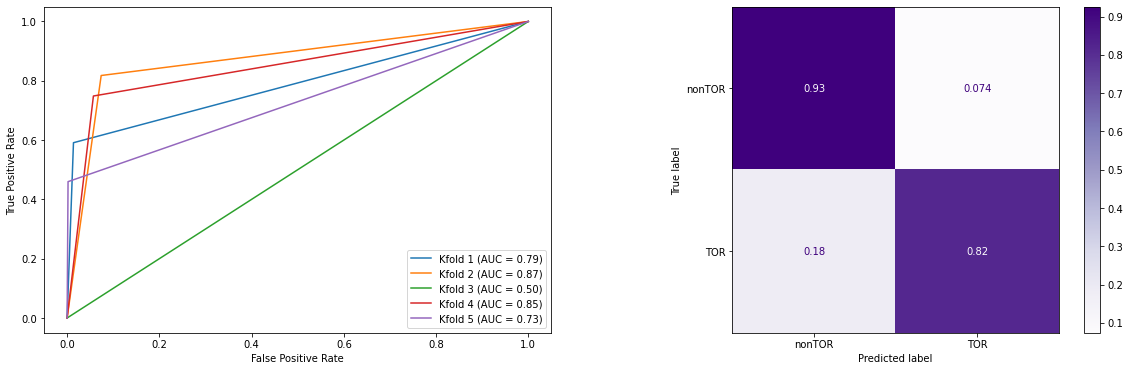

In [26]:
train_predict_kfold(Perceptron, **percep_params)

In [27]:
def train_with_80(ClassifierModel, **classifier_kwargs):    
    clf = make_pipeline(MinMaxScaler(feature_range=(0,1)),
                        ClassifierModel(**classifier_kwargs))

    start_time = datetime.now()
    clf.fit(X, y)
    train_time = datetime.now() - start_time
    
    print('Tempo de treino:', train_time)

    return clf

In [28]:
knn = train_with_80(KNeighborsClassifier, **knn_params)

Tempo de treino: 0:00:02.123574


In [29]:
rf = train_with_80(RandomForestClassifier, **rf_params)

Tempo de treino: 0:00:03.565530


In [30]:
svm = train_with_80(SVC, **svm_params)

Tempo de treino: 0:00:44.212818


In [31]:
perceptron = train_with_80(Perceptron, **percep_params)

Tempo de treino: 0:00:00.105303


# Teste
Usando os 20% como dados de produção

In [32]:
X_test = df_20[mantem[:-1]]
y_test = df_20['label']

Tempo de predição: 0:00:00.362275

Precisão: 0.7712865133623369
Erro: 0.051890616938158766


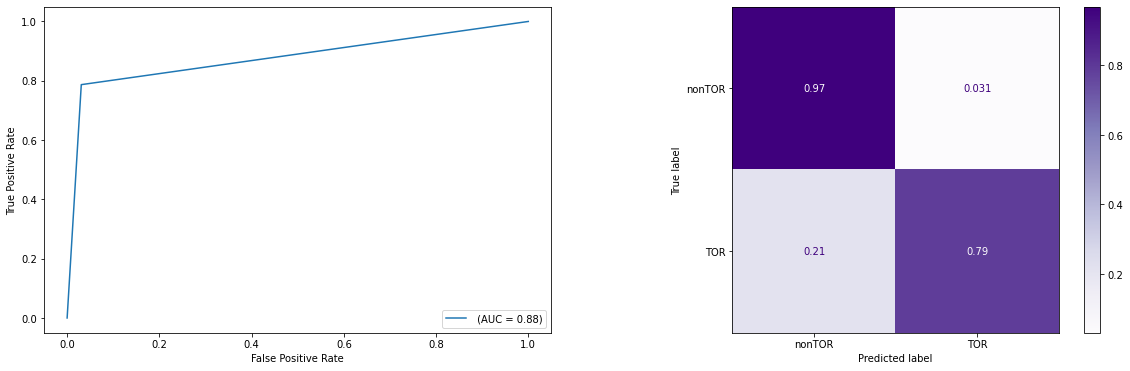

In [33]:
knn_result = predict(knn, X_test, y_test)

Tempo de predição: 0:00:00.123224

Precisão: 0.9119837508463101
Erro: 0.02653497457064937


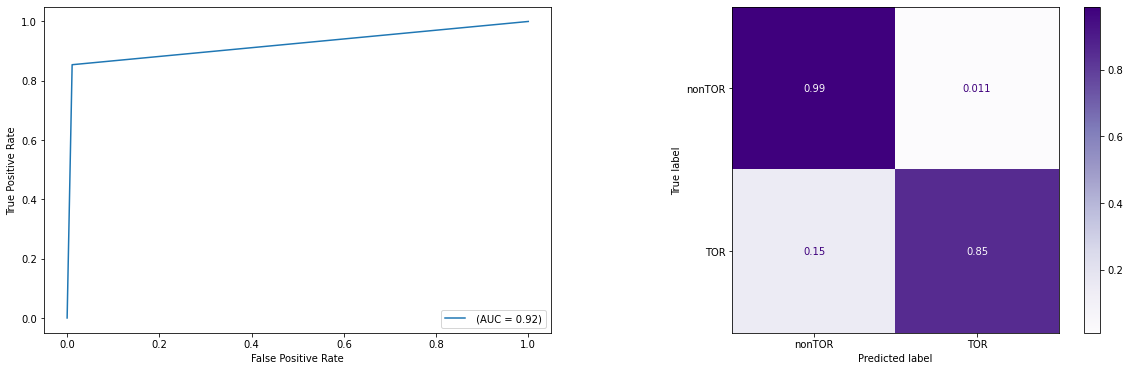

In [34]:
rf_result = predict(rf, X_test, y_test)

Tempo de predição: 0:00:04.377991

Precisão: 0.509427374301676
Erro: 0.11225768408638609


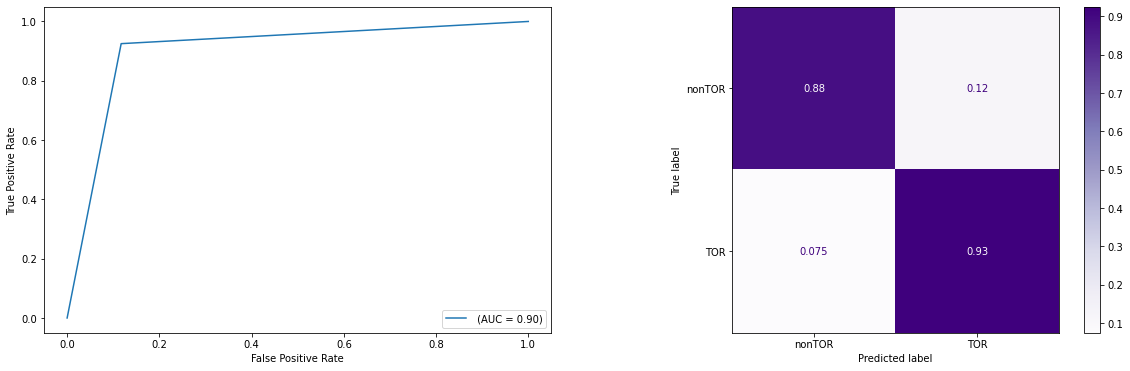

In [35]:
svm_result = predict(svm, X_test, y_test)

Tempo de predição: 0:00:00.002961

Precisão: 0.5807303123625165
Erro: 0.08918699786246038


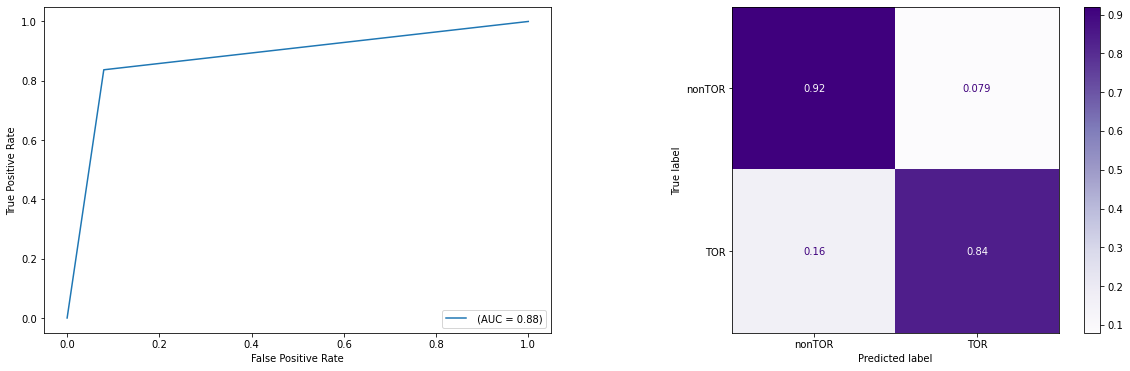

In [36]:
perceptron_result = predict(perceptron, X_test, y_test)

In [37]:
resultado = pd.DataFrame.from_dict({
    'KNN': knn_result,
    'Random Forest': rf_result,
    'SVM': svm_result,
    'Perceptron': perceptron_result
}, orient='index')
resultado.columns = ['Precisão', 'Erro', 'AUC', 'nonTOR (TN)', 'TOR (TP)']

In [38]:
resultado

,Precisão,Erro,AUC,nonTOR (TN),TOR (TP)
KNN,0.771287,0.051891,0.878122,0.969308,0.786937
Random Forest,0.911984,0.026535,0.921656,0.989158,0.854153
SVM,0.509427,0.112258,0.903997,0.882819,0.925174
Perceptron,0.580730,0.089187,0.878775,0.920517,0.837032


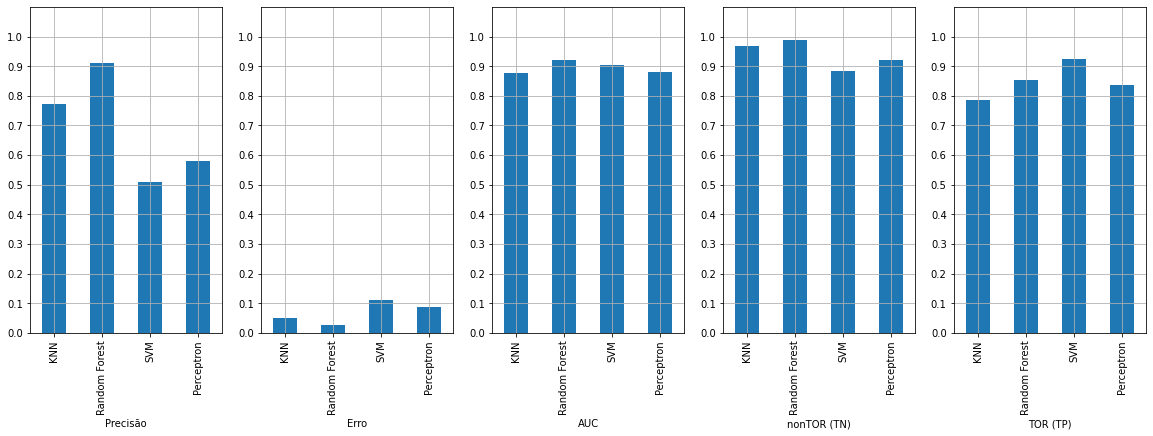

In [39]:
fig, axs = plt.subplots(1, len(resultado.columns), figsize=(20,6))
for idx, coluna in enumerate(resultado.columns):
    resultado[coluna].plot.bar(grid=True, ax=axs[idx])
    axs[idx].set_xlabel(coluna)
    axs[idx].set_ylim((0, 1.1))
    axs[idx].yaxis.set_ticks(np.arange(0, 1.1, 0.1))
plt.show()

# Conclusões

Olhando a grosso modo, o Random Forest parece a melhor solução para classificar tráfegos TOR-nonTOR:

- Tem a melhor precisão
- Menor erro
- Maior área sob a curva ROC.

No entanto, o dataset de teste tem muito mais amostras nonTOR do que TOR, que é justamente onde o Random Forest tem a melhor taxa de acerto. Logo, num ambiente onde sabemos que o tráfego em sua maioria não usa TOR, o Random Forest é a solução ideal.

Agora, o algoritmo que tem a melhor taxa de acerto nas amostras TOR é o SVM. Dá pra perceber que a sua precisão não foi muito boa, mas acredito que isso seja resultado do dataset desbalanceado. Outra desvantagem do SVM é o tempo de treino. Portanto, se for necessário ficar retreinando o modelo, talvez seja melhor ficar com Random Forest mesmo.

# Em resumo
- Usar o modelo **Random Forest** quando:
    - Se espera acertar mais detecção de tráfego nonTOR
    - Sem tempo para treino e/ou retreino
    - Necessidade de detecção executada na casa de milisegundos
- Usar o modelo **SVM** quando:
    - Se espera acertar mais detecção de tráfego TOR

